**Orderbook probability analysis tool**

**Reference:** https://github.com/Exocharts/exocharts-desktop/blob/main/ORDERBOOK-PROBABILITY.ipynb

**Description:** <br>
Previous tool to calculate probabilities of market going up from orderbook had some issues. <br> 

One of them was that volumes are measured in milions, sometimes tens of million so the integral calculation fails or does not get to the final answer, or just outputs 0.0 sometimes. In this notebook there is normalization where the bigger values is set to 100 and the smaller is normalized to that. This means it does not matter how big the numbers get, it will always get the correct answer. <br> 

Also as this normalization is being done and results are stored in history, later calculations might already be stored so only a lookup of O(n) is needed. <br>

New function analyze() is added that reads the ticker data and number of rows for analyzing (hundreds of millions can take 12+hours). This function calculates probabilities, plots their histogram (for a sanity check), calculated accuracy for long and short positions based on different cutoff points and plots the result


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import scipy.integrate as spi
import matplotlib.pyplot as plt
options={'limit':10000000}
history = {}

def calc_integral(bidvol, askvol):
    if bidvol > askvol:
      askvol = askvol*100/bidvol
      bidvol = 100

    if bidvol < askvol:
      bidvol = bidvol*100/askvol
      askvol = 100

    if bidvol == askvol:
      return 0.5

    if (bidvol, askvol) in history:
        return history[(bidvol, askvol)]
    integrand = lambda t :((2 - np.cos(t) - np.sqrt( (2-np.cos(t))**2 - 1 ))**askvol)*np.sin(bidvol*t)*np.cos(t/2)/np.sin(t/2)
    a = 0.
    b = np.pi
    result, error = spi.nquad(integrand, [[a, b]], opts=options)
    history[(bidvol, askvol)]  = result/np.pi
    return history[(bidvol, askvol)]

In [ ]:
def analyze(ticker, nrows):
  d = pd.read_csv("/content/drive/MyDrive/CRYPTO OB DATA/"+ ticker + ".csv", nrows = nrows)
  p = []
  for i in tqdm(range(nrows)):
    p.append(calc_integral(d.bid_amount[i], d.ask_amount[i]))
  d["p"] = p
  d.p.hist()
  plt.show()
  d["mid"] = (d.ask_price + d.bid_price)/2
  d = d.dropna()
  d["wentup"] = (d.mid.shift(-1) - d.mid) > 0
  d["wentdown"] = (d.mid.shift(-1) - d.mid) < 0


  cutoffs = []
  longaccuracys = []
  shortaccuracys = []
  lenlongs = []
  lenshorts = []
  for i in tqdm(range(1, 100)):
      c = i/100
      cutoffs.append(c)
      longpredictions = d[d.p > c]
      shortpredictions = d[d.p < c]
      longaccuracys.append(100*np.sum(longpredictions.wentup) / len(longpredictions))  
      shortaccuracys.append(100*np.sum(shortpredictions.wentdown)  / len(shortpredictions)) 
      lenlongs.append(len(longpredictions))
      lenshorts.append(len(shortpredictions))

  plt.plot(cutoffs, longaccuracys)
  plt.plot(cutoffs, shortaccuracys)
  plt.show()
  return pd.DataFrame.from_dict({'long': longaccuracys, 'lenlong': lenlongs, 'short' : shortaccuracys, 'lenshort': lenshorts, 'cutoff' : cutoffs})


In [ ]:
ROWSTOANALYZE = 1000000

100%|██████████| 10000000/10000000 [1:36:55<00:00, 1719.54it/s]


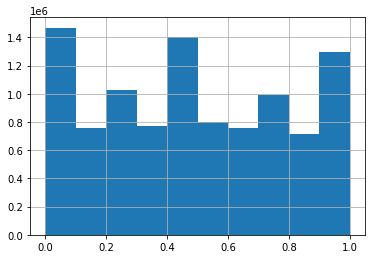

100%|██████████| 99/99 [00:45<00:00,  2.19it/s]


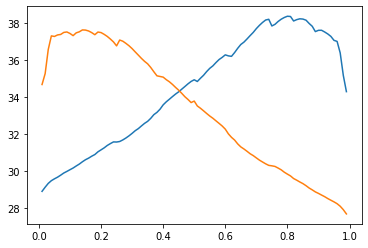

,long,lenlong,short,lenshort,cutoff
0,28.908458,9550212,34.692122,449788,0.01
1,29.132970,9369879,35.281636,630121,0.02
2,29.338972,9215725,36.591119,784275,0.03
3,29.486492,9063964,37.324526,936036,0.04
4,29.587037,8970540,37.293921,1029460,0.05
...,...,...,...,...,...
94,37.083462,919515,28.339345,9080485,0.95
95,37.026743,838286,28.239858,9161714,0.96
96,36.404401,721215,28.102871,9278785,0.97
97,35.187380,596569,27.916502,9403431,0.98


In [ ]:
analyze("DOGE", ROWSTOANALYZE)

100%|██████████| 10000000/10000000 [1:36:31<00:00, 1726.77it/s]


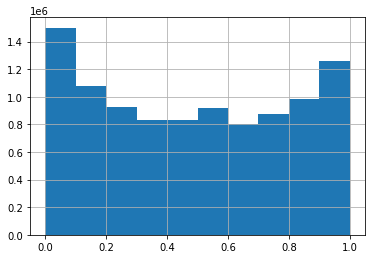

100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


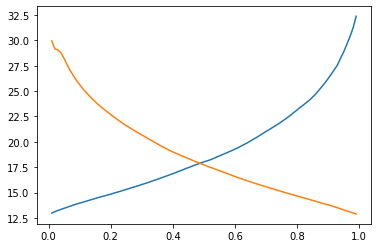

,long,lenlong,short,lenshort,cutoff
0,12.971950,9866335,29.945760,133665,0.01
1,13.120723,9678948,29.164746,321052,0.02
2,13.233158,9488536,29.053267,511464,0.03
3,13.344907,9323265,28.764731,676735,0.04
4,13.447476,9173692,28.197355,826308,0.05
...,...,...,...,...,...
94,28.881936,640795,13.286545,9359205,0.95
95,29.622520,509457,13.187970,9490543,0.96
96,30.370649,375504,13.087626,9624496,0.97
97,31.223436,230106,12.988769,9769894,0.98


In [ ]:
analyze("SOL", ROWSTOANALYZE)

  1%|          | 119021/10000000 [00:39<31:28, 5232.49it/s]/usr/local/lib/python3.8/dist-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 10000000/10000000 [1:08:47<00:00, 2422.91it/s]


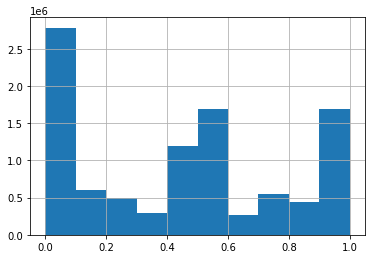

100%|██████████| 99/99 [00:46<00:00,  2.12it/s]


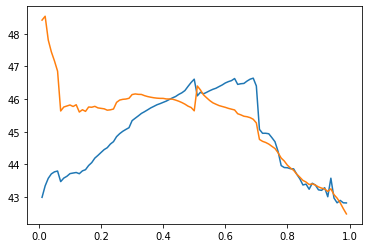

,long,lenlong,short,lenshort,cutoff
0,42.993509,9065480,48.420531,934238,0.01
1,43.344387,8594430,48.538805,1405288,0.02
2,43.575428,8197441,47.811019,1802277,0.03
3,43.712155,8021874,47.447018,1977844,0.04
4,43.773870,7854245,47.170717,2145473,0.05
...,...,...,...,...,...
94,42.972598,1292398,43.075745,8707320,0.95
95,42.826007,1190634,42.969984,8809084,0.96
96,42.899831,1052820,42.826385,8946898,0.97
97,42.826391,836643,42.648707,9163075,0.98


In [ ]:
analyze("XBT", ROWSTOANALYZE)

100%|██████████| 10000000/10000000 [12:02<00:00, 13846.72it/s]


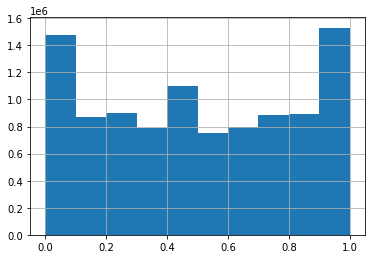

100%|██████████| 99/99 [00:45<00:00,  2.19it/s]


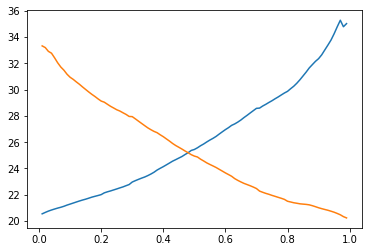

,long,lenlong,short,lenshort,cutoff
0,20.548944,9656569,33.327510,343431,0.01
1,20.655834,9453150,33.200146,546850,0.02
2,20.755969,9294425,32.912164,705575,0.03
3,20.838989,9142790,32.773416,857210,0.04
4,20.914291,9023366,32.419617,976634,0.05
...,...,...,...,...,...
94,34.249540,1028262,20.671903,8971738,0.95
95,34.778235,902576,20.578100,9097424,0.96
96,35.279842,750369,20.475444,9249631,0.97
97,34.786923,562332,20.335129,9437668,0.98


In [ ]:
analyze("LTC", ROWSTOANALYZE)

**Conclusion:** Based on results, the best accuracy was on BNB ticker, with long position cutoff being 0.99, although out of 100000 orderbook updates, only 110 positions weere made with 53.6% accuracy